Sample code for using Kernel Density
<ul>
    <li>Created this small IPython notebook because have problems creating probabilities.  The values are too small.
    <li>It is expected that you have russell3000.csv file in the same directory as the script.  Or adjust accordingly.
    <li>russell3000.csv is the name of the file that has daily eod prices for Russell3000 index constituents.
</ul>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import pandas as pd
from scipy.stats import entropy
%matplotlib inline

In [2]:
def get_returns_daily_df(filename):
    """Load the data and calculate log return.  Remove the 
    first row because it will always be NaN."""
    df = pd.read_csv(filename) # 'russell3000.csv'
    df.set_index(df['Dates'], inplace=True)
    df.drop('Dates', axis=1, inplace=True)
    df_ret = np.log(df / df.shift())
    df_ret.drop(['1/2/1986'], inplace=True)
    return df_ret

In [3]:
df = get_returns_daily_df('russell3000.csv')

In [128]:
data = df.ix[0].copy()
# data.dropna(inplace=True)
# digitize function to avoid values in x are beyond the bounds of bins, 0 or len(bins) is returned as appropriate.
epsilon = 0.001
lower_bound = np.min(data)
upper_bound = np.max(data) + epsilon
bins = np.linspace(lower_bound, upper_bound, 10)
digitized = np.digitize(data, bins)
bin_count = [data[digitized == i].count() for i in range(1, len(bins))]
bin_pr = bin_count/np.sum(bin_count)

In [137]:
bin_count

[1, 2, 6, 17, 147, 132, 23, 5, 5]

In [129]:
bin_pr

array([ 0.00295858,  0.00591716,  0.01775148,  0.05029586,  0.43491124,
        0.39053254,  0.06804734,  0.0147929 ,  0.0147929 ])

In [138]:
data_pr = [bin_pr[digitized[i]-1]/bin_count[digitized[i]-1] if not np.isnan(data[i]) else np.nan for i in range(0, len(digitized))]

In [131]:
try:
    data_pr = []
    for i in range(0, len(digitized)):
        if not np.isnan(data[i]):
#             print("index: %d \t data[%d] = %f \t digitized[%d] = %d" % (i, i, data[i], i, digitized[i]))
            data_pr.append(bin_pr[digitized[i]-1])
        else: 
            data_pr.append(np.nan)
#             print("NAN ..... index: %d \t data[%d] = %f \t digitized[%d] = %d" % (i, i, data[i], i, digitized[i]))
    print("Finally done!")
except IndexError:
    print("index: %d \t data[%d] = %f \t digitized[%d] = %d" % (i, i, data[i], i, digitized[i]))

# data_pr = [bin_pr[i-1] if not np.isnan(digitized[i]) else NaN for i in range(0, len(digitized))]

Finally done!


In [50]:
# data = df[0:60].copy()
# data.dropna(axis=1, inplace=True)

# Gaussian KDE
# kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(data)
# log_dens = kde.score_samples(data)
# kd_vals = np.exp(log_dens)

In [85]:
X = df.ix[0].copy()
X.dropna(inplace=True)
X = X.reshape(-1, 1)
kde.fit(X)
log_dens = kde.score_samples(X)
kd_vals_i = np.exp(log_dens)

In [86]:
Y = df.ix[1].copy()
Y.dropna(inplace=True)
Y = Y.reshape(-1, 1)
kde.fit(Y)
log_dens = kde.score_samples(Y)
kd_vals_j = np.exp(log_dens)

In [99]:
min_len = min(len(kd_vals_i), len(kd_vals_j))
entropy(kd_vals_i[0:min_len], kd_vals_j[0:min_len])

4.20833470586926e-07

In [100]:
# -------------------------------------------------------------------
# kd_vals has the probabilities estimated from gaussian distribution
# important: the kde changes in every loop because the data moves
# by 1 day
# -------------------------------------------------------------------
def get_kl_matrix(df):
    rows = len(df)
    kl = np.zeros((rows, rows))
    
    kde = KernelDensity(kernel='gaussian', bandwidth=0.75)
    for i in range(0, rows):
        for j in range(0, rows):
            if i == j:
                kl[i,j] = 0
            else:            
                X = df.ix[i].copy()
                X = X.reshape(-1, 1)
                kde.fit(X)
                log_dens = kde.score_samples(X)
                kd_vals_i = np.exp(log_dens)

                Y = df.ix[j].copy()
                Y = Y.reshape(-1, 1)
                kde.fit(Y)
                log_dens = kde.score_samples(Y)
                kd_vals_j = np.exp(log_dens)

                min_len = min(len(kd_vals_i), len(kd_vals_j))
                entropy(kd_vals_i[0:min_len], kd_vals_j[0:min_len])
                
                kl[i,j] = entropy(kd_vals_i, kd_vals_j)
            
    return kl

The code above works.  But the kd_vals are extremely small.  I have spent enough time to convince myself that I need your help.
The lines below makes runs this in a loop.  This is extracted from russell.py, the main code file for faster prototyping.

In [37]:
width = 60
threshold = 0.9

In [103]:
def calc_dim_using_imml(df, width = 60, threshold = 0.9):
    max_rows = df.shape[0] - (width + 1)    
    dates = []
    imml_svd_dimensions = []
    imml_eig_dimensions = []
    
    for i in range(0, max_rows):
        data = df[i:i+width].copy()
        orig_cols_len = len(data.columns)
        data.dropna(axis=1, inplace=True)
        new_cols_len = len(data.columns)
        ds = df.index[i+width]
        
        # -------------------------------------------------------------------
        # calculate KL divergence using kd_vals rows
        # this should be a width x width matrix, with 0 in diagonals
        # we will do SVD of that matrix
        # -------------------------------------------------------------------
        kl = get_kl_matrix(data)
        
        print(kl)
        
        s = '%d.)  orig_cols_len=%d   new_cols_len=%d    date=%s\n' % (i, orig_cols_len, new_cols_len, ds)
        print(s)
        
        U, s_svd, V = np.linalg.svd(kl, full_matrices=False)
        plt.figure(figsize=(20,10))
        plt.title('DR using SVD')
        plt.plot(s_svd)
        
        break

[[  0.00000000e+00   4.23239786e-07   1.06205257e-06 ...,   1.32560901e-06
    2.43156090e-06   6.25050876e-07]
 [  4.23745128e-07   0.00000000e+00   1.13050548e-06 ...,   1.34256549e-06
    2.28066856e-06   6.39752542e-07]
 [  1.05951576e-06   1.12724183e-06   0.00000000e+00 ...,   2.19709849e-06
    2.18216342e-06   1.51708621e-06]
 ..., 
 [  1.32106200e-06   1.33520972e-06   2.19332753e-06 ...,   0.00000000e+00
    2.95612168e-06   1.78940640e-06]
 [  2.41604553e-06   2.26515248e-06   2.17841810e-06 ...,   2.94725435e-06
    0.00000000e+00   2.59712468e-06]
 [  6.24619749e-07   6.38589193e-07   1.51866565e-06 ...,   1.79557564e-06
    2.61174880e-06   0.00000000e+00]]
0.)  orig_cols_len=2966   new_cols_len=335    date=4/1/1986



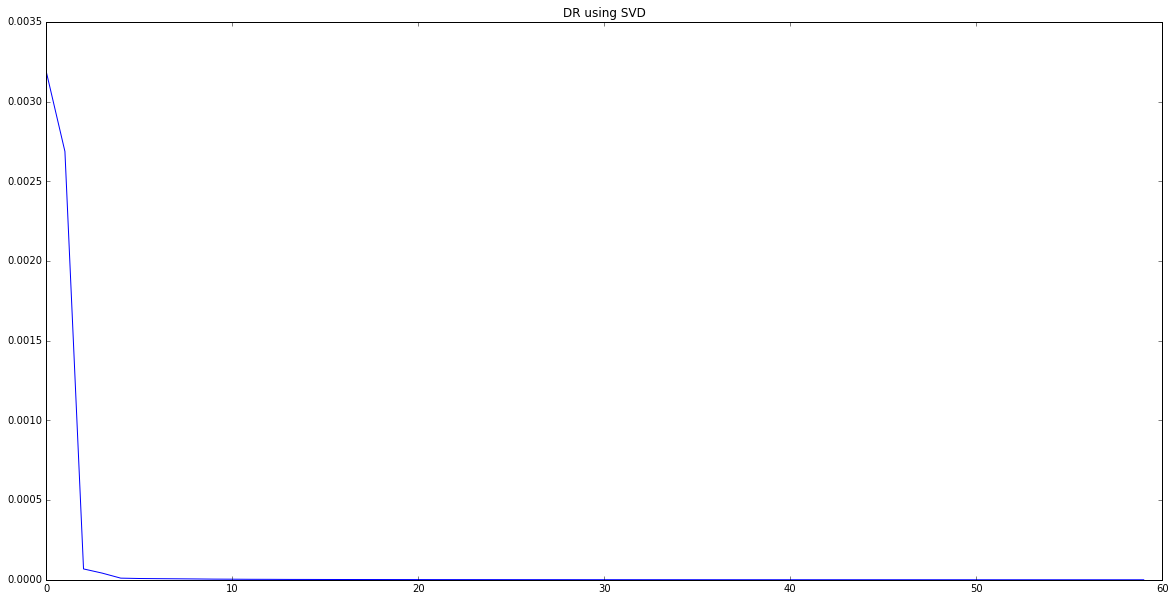

In [104]:
calc_dim_using_imml(df, width, threshold)